Importing relevant packages

In [66]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

Downloading and unzipping the dataset

In [2]:
# # Downloading dataset
# !wget https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/NSE-Tata-Global-Beverages-Limited.zip -O Dataset.zip
    
# # Unzipping
# !unzip Dataset.zip -d Dataset

In [3]:
df = pd.read_csv("Dataset/NSE-Tata-Global-Beverages-Limited.csv")
df.head(10)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
5,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914.0,7162.35
6,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859.0,11859.95
7,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909.0,5248.60
8,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368.0,5503.90
9,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509.0,7999.55


Declaring the index column and transforming it to datetime format

In [4]:
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df["Date"]

Plotting the closing price

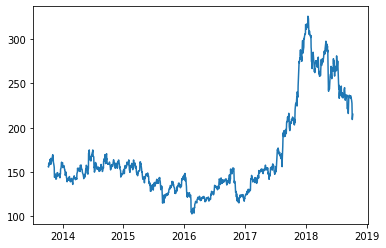

In [5]:
plt.plot(df["Close"], label = "Closing Price")
plt.show()

Sorting the dataset using the date time and filter Date and Close columns

In [10]:
data = df.sort_index(ascending = True, axis = 0)
new_dataset = pd.DataFrame(index = range(0, len(df)), columns = ["Date", "Close"])
new_dataset["Date"] = data["Date"].values[:]
new_dataset["Close"] = data["Close"].values[:]
new_dataset.head()

,Date,Close
0,2013-10-08,155.80
1,2013-10-09,155.55
2,2013-10-10,160.15
3,2013-10-11,160.05
4,2013-10-14,159.45


Normalizing the new dataset that has the Date and Closing Price

In [11]:
scaler = MinMaxScaler(feature_range = (0, 1))
final_dataset = new_dataset.values

#80% training set and 20% validation set

train_set = final_dataset[0:int(0.8*len(final_dataset)),:]
valid_set = final_dataset[int(0.8*len(final_dataset)):,:]
print(len(train_set), len(valid_set))

988 247


In [12]:
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis = 1, inplace = True)

scaled_data = scaler.fit_transform(new_dataset)

In [15]:
x_train = []
y_train = []
for i in range(60, len(train_set)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i, 0])

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

(928, 60) (928,)


In [20]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(928, 60, 1)


Building LSTM Model

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(x_train, y_train, epochs = 10, batch_size=1, verbose=2)

Epoch 1/10
928/928 - 14s - loss: 5.1018e-04
Epoch 2/10
928/928 - 14s - loss: 3.7182e-04
Epoch 3/10
928/928 - 14s - loss: 2.9856e-04
Epoch 4/10
928/928 - 20s - loss: 2.6151e-04
Epoch 5/10
928/928 - 16s - loss: 2.5162e-04
Epoch 6/10
928/928 - 15s - loss: 2.3741e-04
Epoch 7/10
928/928 - 14s - loss: 2.3694e-04
Epoch 8/10
928/928 - 14s - loss: 2.3299e-04
Epoch 9/10
928/928 - 14s - loss: 2.4473e-04
Epoch 10/10
928/928 - 14s - loss: 2.3488e-04


Save model

In [32]:
model.save("Stock_Prices_Prediction.model")

INFO:tensorflow:Assets written to: Stock_Prices_Prediction.model/assets


INFO:tensorflow:Assets written to: Stock_Prices_Prediction.model/assets


Predict using the model

In [40]:
input_data = new_dataset[len(new_dataset) - len(valid_set) - 60:].values
input_data = scaler.transform(input_data)
x_test = []
for i in range(60, input_data.shape[0]):
    x_test.append(input_data[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_price = model.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)

Visualize predicted data

/home/maina/Tensorflow2.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


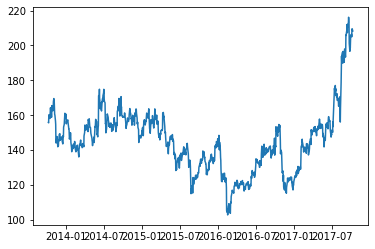

In [43]:
train_data = new_dataset[:int(0.8*len(final_dataset))]
valid_data = new_dataset[int(0.8*len(final_dataset)):]
valid_data["Predictions"] = predicted_price
plt.plot(train_data["Close"])
plt.show()

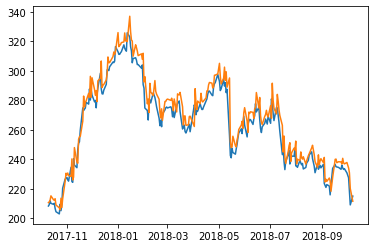

In [46]:
plt.plot(valid_data[["Close", "Predictions"]])

In [67]:
classification_report(valid_data["Close"].values, valid_data["Predictions"].values)

ValueError: continuous is not supported